In [106]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import LinearLocator, LogLocator, MaxNLocator, MultipleLocator
import numpy as np
from cmcrameri import cm

import scipy.integrate as integ

In [15]:
# %matplotlib widget

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [16]:
# constants
sbc = 5.67e-8   # stefan-boltzman constant
M_E = 6e24 # Rarth mass [kg]
day = 24.0*60*60 # length of day in seconds
year = 365.24 * day

In [117]:
class planet():

    def __init__(self):

        # parameters
        self.c_p = 703.0     # heat capacity [J kg-1 K-1]
        self.rho = 3000.0    # density [kg m-3]
        self.S_0 = 1000.0    # instellation [W m-2]
        self.T_0 = 2500.0    # initial temperature [K]
        self.T_s = 1500.0    # solidus temperature [K]
        self.alb = 0.7       # shortwave albedo
        self.ems = 0.7       # longwave emissivity
        self.M_p = 1 * M_E   # mass of planet [kg]
        self.F_i = 0.0       # internal heat production [W m-2]

        # result
        self.sol_x = None
        self.sol_y = None


    # ode
    def _ode(self, t, y):

        # temperature at time = t
        Tt = y[0]

        # RHS
        coeff = (np.pi/self.c_p) * (3.0/4)**(2.0/3) * (self.rho * self.rho * self.M_p)**(-1.0/3)

        up = (4.0 * self.ems * sbc)*(Tt**4)
        dn = (self.S_0)*(1-self.alb) + (4.0)*(self.F_i)

        out = coeff * (dn-up)

        return (out,)

    # solidification event
    def _solid(self, t, y):
        if y[0] <= self.T_s:
            return 0.0
        else:
            return np.inf
    _solid.terminal = True


    # solve
    def solve(self, t_max, nsamps=1000, stop_solid=False):

        t_span = (0,t_max*year)
        t_eval = np.linspace(t_span[0], t_span[1], nsamps)

        if stop_solid:
            events = (self._solid,)
        else:
            events = None

        result = integ.solve_ivp(self._ode, t_span, (self.T_0,),
                                    first_step=day/2, events=events, t_eval=t_eval)

        self.sol_x = result.t / year
        self.sol_y = result.y[0]
        succ = result.success
        if not succ:
            print("Success:",succ)
            print("\t",result.message)

        return self.sol_x, self.sol_y



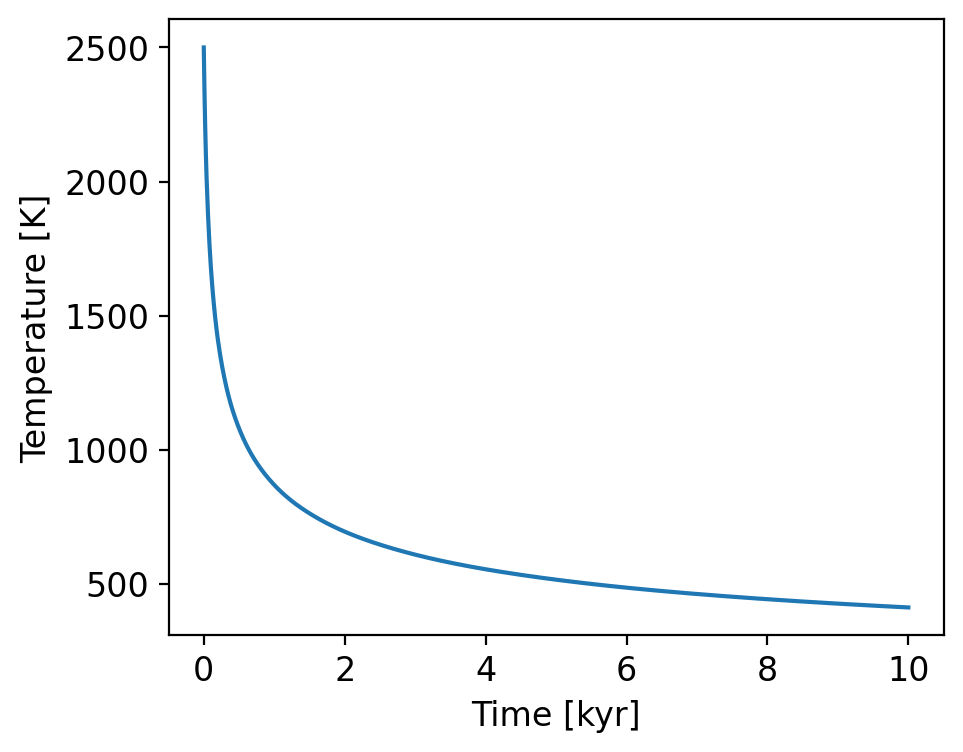

In [118]:
# single case
fig, ax = plt.subplots(1,1, figsize=(5,4))

pl = planet()
sol_x, sol_y = pl.solve(1e4)

ax.plot(sol_x/1e3, sol_y)

ax.set_xlabel("Time [kyr]")
ax.set_ylabel("Temperature [K]")

plt.show()

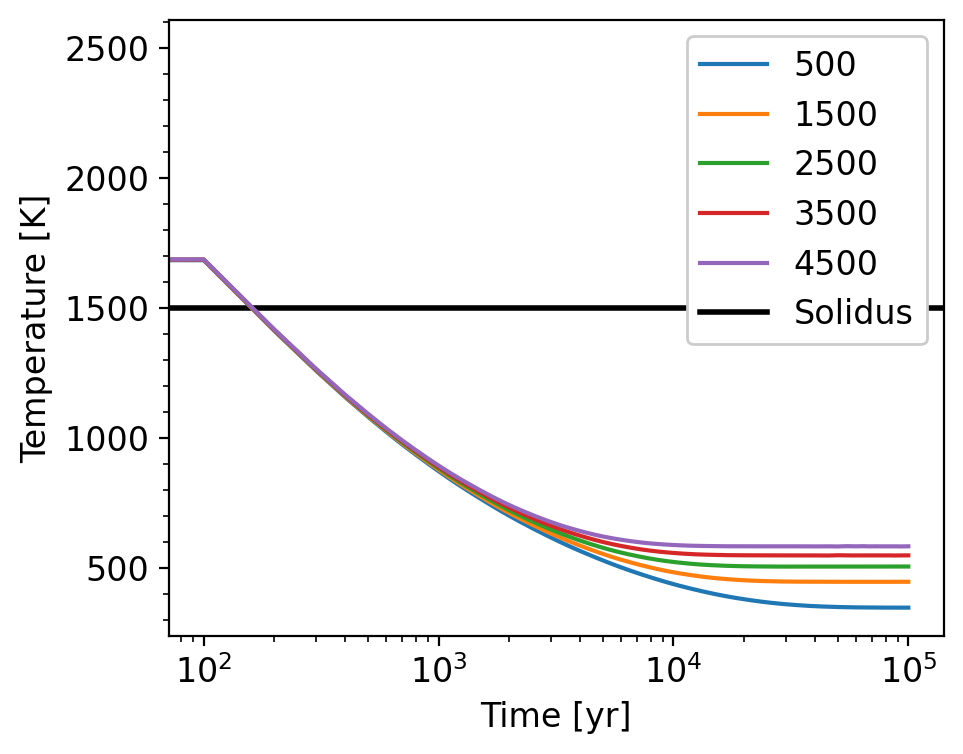

In [120]:
# multiple case
fig, ax = plt.subplots(1,1, figsize=(5,4))

# for x in np.arange(0.5, 2.5, 0.5):
for x in np.arange(500, 5500, 1000):
    pl = planet()

    # pl.M_p = x * M_E
    pl.F_i = x

    # solve and plot
    sol_x, sol_y = pl.solve(t_max=1e5)
    ax.plot(sol_x, sol_y, label=x)

ax.axhline(pl.T_s, label="Solidus", color='k', lw=2, zorder=0)

ax.set_xlabel("Time [yr]")
ax.set_xscale("log")
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.set_ylabel("Temperature [K]")
ax.legend(framealpha=1.0)

plt.show()